# Interactive Visualization of ML Model Prediction 

In this tutorial, we'll revisit the Iris dataset and [Bokeh](http://bokeh.pydata.org/en/latest/) and demonstrate how to visualize decision boundaries in 2D for machine learning models.

### Bokeh Docs

[Install & Quickstart](http://bokeh.pydata.org/en/latest/docs/user_guide/quickstart.html) | [Tutorials](http://nbviewer.jupyter.org/github/bokeh/bokeh-notebooks/blob/master/tutorial/00%20-%20intro.ipynb) | [Bokeh Concepts](http://bokeh.pydata.org/en/latest/docs/user_guide/quickstart.html) | [Basic Plotting](http://bokeh.pydata.org/en/latest/docs/user_guide/styling.html#plots) | [Axes](http://bokeh.pydata.org/en/latest/docs/user_guide/styling.html#axes) | [Legends](http://bokeh.pydata.org/en/latest/docs/user_guide/styling.html#legends) 

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import random
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, ColumnDataSource
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

%matplotlib inline
output_notebook()

Loading BokehJS ...

### Import data and run 2D PCA

In [2]:
# Load data
iris = datasets.load_iris()
iris_X, iris_y = iris.data, iris.target
iris_colors = list(iris.target_names)

### Convert to Panda Dataframes

Bokeh understand dataframes and can use the header information for coloring -- which is modern and awesome. So let's use that.

In [3]:
# you can create one df with iris data only (no target)
iris_data = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])

# ...and create a single-column df with targets
iris_target = pd.DataFrame(data=iris['target'], columns=['target'])

# or, if you want all of it together, merge them
iris_all = iris_data.copy() # copy first to avoid collisions
iris_all = iris_all.assign(target=iris_target) # assign target as new col

# Print one of the dataframes
with pd.option_context('display.max_rows', 3, 'display.max_columns', 2):
    print("\nIris data and target:\n___\n", iris_all)


Iris data and target:
___
      sepal length (cm)   ...    target
0                  5.1   ...         0
..                 ...   ...       ...
149                5.9   ...         2

[150 rows x 5 columns]


We want the legend to reflect proper names for _iris_:
- let's create a new df with str instead of ints
- copy the dataframe first to avoid collisions later
- iris_colors = list of iris flower names

In [4]:
# Get iris species names instead of values
iris_target_str = iris_target.copy().replace([0,1,2], iris_colors) 

# 2D PCA dataframe
X_pca2D = PCA(n_components=2).fit_transform(iris_X)
iris_PCA2D = pd.DataFrame(data = X_pca2D, columns = ['PC1', 'PC2'])
iris_PCA2D = iris_PCA2D.assign(target=iris_target)
iris_PCA2D = iris_PCA2D.assign(label=iris_target_str)
print("Iris 2D PCA:\n___\n", iris_PCA2D.head())

Iris 2D PCA:
___
         PC1       PC2  target   label
0 -2.684126  0.319397       0  setosa
1 -2.714142 -0.177001       0  setosa
2 -2.888991 -0.144949       0  setosa
3 -2.745343 -0.318299       0  setosa
4 -2.728717  0.326755       0  setosa


## Visualizing Predictions Generated by Classifiers

We'll examine training and test data, along with predictions, for a few select classifiers:
- K-Nearest Neighbors
- Logistic Regression

In [5]:
# Set seed
np.random.seed(42)

# For this exercise, we'll train using the PCA data (iris_PCA2D) - train/test split of 0.6, 0.4
# X_train, X_test, y_train, y_test = train_test_split(X_pca2D, iris_y.ravel(), test_size=0.4)
X_train, X_test, y_train, y_test = train_test_split(iris_PCA2D[['PC1', 'PC2']], iris_PCA2D['target'], test_size=0.4)

# Select classifier & train
k_neighbors = 2
knn_iris = KNeighborsClassifier(n_neighbors=2)
knn_iris.fit(X_train, y_train) 

# Return predictions on withheld test data and score
# -- note: knn also has the predict_proba method 
#          will let you know probability for each target
knn_predictions = knn_iris.predict(X_test)
print(f"{k_neighbors}NN model accuracy: {knn_iris.score(X_test, y_test)}")

2NN model accuracy: 0.95


In [6]:
# Add predictions column
iris_PCA2D = iris_PCA2D.assign(predictions=knn_iris.predict(iris_PCA2D[['PC1', 'PC2']]))
colormap_int_label = {'0': 'setosa', '1': 'versicolor', '2': 'virginica'}
predictions_label = [colormap_int_label[str(x)] for x in iris_PCA2D.predictions]
iris_PCA2D = iris_PCA2D.assign(predictions_label=predictions_label)
iris_PCA2D.head()

,PC1,PC2,target,label,predictions,predictions_label
0,-2.684126,0.319397,0,setosa,0,setosa
1,-2.714142,-0.177001,0,setosa,0,setosa
2,-2.888991,-0.144949,0,setosa,0,setosa
3,-2.745343,-0.318299,0,setosa,0,setosa
4,-2.728717,0.326755,0,setosa,0,setosa


## Plotting with Decision Boundaries

Now for the fun part (yay!) -- plotting decision boundaries! 

In order to plot a decision boundary you do the following:
 1. Create a granular X-Y matrix using np.meshgrid
 2. Make a "prediction" for each point in the mesh
 3. Plot the predictions as a layer on the actual data

In [7]:
def create_mesh(matrix_2D, bound=.1, step=.05):
    """
    create_mesh will generate a mesh grid for a given matrix
    
    matrix_2D: input matrix (numpy)
    bound:     boundary around matrix (absolute value)
    step:      step size between each point in the mesh
    """

    # set bound as % of average of ranges for x and y
    bound = bound*np.average(np.ptp(matrix_2D, axis=0))
    
    # set step size as % of the average of ranges for x and y 
    step = step*np.average(np.ptp(matrix_2D, axis=0))

    # get boundaries
    x_min = matrix_2D[:,0].min() - bound
    x_max = matrix_2D[:,0].max() + bound
    y_min = matrix_2D[:,1].min() - bound 
    y_max = matrix_2D[:,1].max() + bound
    
    # create and return mesh
    mesh = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    return mesh


def predict_mesh(trained_clf, mesh):
    """
    predict_mesh will generate predictions for all points in a mesh grid
    
    clf:    sklearn classifier (e.g. knn)
    mesh:   tuple returned by create mesh (xx, yy)
    """
    
    # make predictions based on all values in mesh and return
    predictions = trained_clf.predict(np.c_[mesh[0].ravel(), mesh[1].ravel()])
    predictions = predictions.reshape(mesh[0].shape)    
    return predictions

In [8]:
# Create decision boundaries/meshgrid with predictions in PCA space
iris_mesh = create_mesh(iris_PCA2D[['PC1', 'PC2']].values, step=0.02)

# Get prediction for each point in the mesh
iris_mesh_pred = predict_mesh(knn_iris, iris_mesh)

# Unravel the matrices, concatenate, add to a dataframe (mesh + predictions)
processed_mesh = np.c_[iris_mesh[0].ravel(), iris_mesh[1].ravel(), iris_mesh_pred.ravel()]
df_mesh = pd.DataFrame(processed_mesh, columns=['xx','yy','pred'])
df_mesh.head()

,xx,yy,pred
0,-3.706783,-1.74895,0.0
1,-3.610187,-1.74895,0.0
2,-3.513591,-1.74895,0.0
3,-3.416995,-1.74895,0.0
4,-3.320400,-1.74895,0.0


Now we have the data we need to make our plot:
- iris_PCA2D with original data (in PCA space), targets, and predictions


## Plot the Decision Boundary
Now let's plot the decision boundary -- this one is more involved. 

If you're plotting something quick-and-dirty -- use *holoviews*.

If you're overlaying different plots (e.g. decisions boundaries and data), you'll need to use *bokeh.plotting* and maybe *bokeh.models*.

Hints:
- *holoviews* is a very high-level API for plots, with minimal fussing.
- *plotting* is a high-level API for plots with more flexibility
- *models* is a low-level API with tons of flexibility and very fussy
- Try *not* to mix the different levels! When in doubt, use *plotting*.

In [9]:
"""
Generate colors and labels/legends
"""
# Create dictionaries for mapping colors
colormap = {'setosa': 'red', 'versicolor': 'green', 'virginica': 'orange'} # for labeled data
colormap_int = {'0': 'red', '1': 'green', '2': 'orange'} # for integers

# color label for targets (e.g. green)
colors = [colormap[t] for t in iris_PCA2D['label']] 
# color label for preds on test data (e.g. green)
colors_pred = [colormap_int[str(p)] for p in knn_predictions] 
# color label for mesh (e.g. green)
colors_mesh = [colormap_int[str(int(m))] for m in df_mesh.pred.ravel()] 

"""
Create ColumnDataSources 
"""
source_data = ColumnDataSource(data=dict(PC1=iris_PCA2D.PC1, 
                                         PC2=iris_PCA2D.PC2,
                                         colors=colors, 
                                         colors_legend=iris_PCA2D.label,
                                         colors_pred_data=iris_PCA2D.predictions_label))

source_test = ColumnDataSource(data=dict(X_test_0=X_test.values[:,0],
                                         X_test_1=X_test.values[:,1],
                                         colors_pred=colors_pred))

source_mesh = ColumnDataSource(data=dict(x=df_mesh.xx.ravel(),
                                         y=df_mesh.yy.ravel(),
                                         colors_mesh=colors_mesh))

"""
Plot
"""
# Initiate Plot
tools_ = ['crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']
p = figure(title="Iris PCA and KNN", tools=tools_)

# axis labels
p.xaxis.axis_label = 'PC1'
p.yaxis.axis_label = 'PC2'

# plots
p1 = p.circle('PC1', 'PC2', fill_color='colors',
              size=7, alpha=0.5, line_alpha=0,
              source=source_data, name='Data')
p2 = p.circle('X_test_0', 'X_test_1', line_color='colors_pred',
              size=10, line_width=3, alpha=1, fill_alpha=0,
              source=source_test, name='Test')
p3 = p.square(x='x', y='y', fill_color='colors_mesh',
              size=12, line_alpha=0, fill_alpha=0.05,
              source=source_mesh, name='Mesh')

# add hovertool
hover_1 = HoverTool(names=['Data'], tooltips=[("truth", "@colors_legend"), ("prediction", "@colors_pred_data")], renderers=[p1])
p.add_tools(hover_1)

show(p)

## To make the code more reusable, let's turn it into a function.

In [10]:
def plot_decision_boundaries(X_2D, targets, labels, 
                             trained_clf, X_test_, colormap_, labelmap_, 
                             step_=0.02, title_="", xlabel_="", ylabel_=""):
    """
    X_2D:        2D numpy array of data (e.g. two features from iris.data or 2D PCA)
    targets:     array of target data (e.g iris.target)
    labels:      array of labels for target data
    trained_clf: previously trained classifier (e.g. KNN)
    X_test_:     test data taken (e.g. from test_train_split())
    colormap_:   map of target:color (e.g. {'0': 'red', ...} )
    labelmap_:   map of target:label (e.g. {'0': 'setosa', ...} )
    step_:       step size for mesh (e.g lower = higher resolution)
    title_:      plot title
    xlabel_:     x-axis label
    ylabel_:     y-axis label
    """
    
    # Create a mesh
    mesh_ = create_mesh(X_2D, step=step_)

    # Get predictions for each point in the mesh
    mesh_pred = predict_mesh(trained_clf, mesh_)
    
    # Get predictions for test data, all data
    test_pred = trained_clf.predict(X_test_)
    data_pred = trained_clf.predict(X_2D)

    # create color vectors [assume targets are last index]
    colors = [colormap_[str(t)] for t in targets]
    colors_test_pred = [colormap_[str(p)] for p in test_pred]
    colors_pred_data = [labelmap_[str(x)] for x in data_pred]
    colors_mesh = [colormap_[str(int(m))] for m in mesh_pred.ravel()]
    
    """ Create ColumnDataSources  """
    source_data = ColumnDataSource(data=dict(X=X_2D[:,0], 
                                             Y=X_2D[:,1],
                                             colors=colors, 
                                             colors_legend=labels,
                                             colors_pred_data=colors_pred_data))


    source_test = ColumnDataSource(data=dict(X_test=X_test_[:,0],
                                                    Y_test=X_test_[:,1],
                                                    colors_test_pred=colors_test_pred))

    source_mesh = ColumnDataSource(data=dict(mesh_x=mesh_[0].ravel(),
                                             mesh_y=mesh_[1].ravel(),
                                             colors_mesh=colors_mesh))    
    
    # Initiate Plot
    tools_ = ['crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']
    p = figure(title=title_, tools=tools_)
    p.xaxis.axis_label = xlabel_
    p.yaxis.axis_label = ylabel_

    # plot all data
    p_data = p.circle('X', 'Y', fill_color='colors',
                  size=10, alpha=0.5, line_alpha=0, 
                  source=source_data, name='Data')
    
    # plot thick outline around predictions on test data
    p_test = p.circle('X_test', 'Y_test', line_color='colors_test_pred',
                  size=12, alpha=1, line_width=3, fill_alpha=0,
                  source=source_test)

    # plot mesh
    p_mesh = p.square('mesh_x', 'mesh_y', fill_color='colors_mesh',
               size = 13, line_alpha=0, fill_alpha=0.05, 
               source=source_mesh)
    
    # add hovertool
    hover_1 = HoverTool(names=['Data'], 
                        tooltips=[("truth", "@colors_legend"), ("prediction", "@colors_pred_data")], 
                        renderers=[p_data])
    p.add_tools(hover_1)

    show(p)
    
    return

## Let's go through the whole flow
Now that we've explored the process and created helper functions, let's rerun:
- importing data
- run PCA
- train a classifier
- get the score
- get our schmancy plot

...with a whole new seed.

In [11]:
""" Let's go through the whole flow but with a 3NN classifier """

# iris data
iris_colormap = {'0': 'red', '1': 'green', '2': 'orange'} 
iris_labelmap = {'0': 'setosa', '1': 'versicolor', '2': 'virginica'} 
X = iris.data
iris_targets = iris.target
iris_labels = [iris_labelmap[str(x)] for x in iris_targets]

# pca
X_pca2D = PCA(n_components=2).fit_transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X_pca2D, iris_targets, test_size=0.4)

# select classifier & train
neighbors_ = 3
knn_rerun = KNeighborsClassifier(n_neighbors=neighbors_)
knn_rerun.fit(X_train, y_train)
knn_rerun_accuracy = knn_rerun.score(X_test, y_test)

# plot
plot_decision_boundaries(X_2D=X_pca2D, 
                         targets=iris_targets, 
                         labels=iris_labels,
                         trained_clf=knn_rerun, 
                         X_test_=X_test,
                         colormap_=iris_colormap, 
                         labelmap_=iris_labelmap,
                         step_=0.02,
                         title_=f"{neighbors_}NN Classifier with {100*knn_rerun_accuracy:.2f}% Accuracy",
                         xlabel_="PC1", ylabel_="PC2")

In [12]:
# select classifier & train
model = SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)
model_accuracy = model.score(X_test, y_test)
model_title=f"Support Vector Machine (Linear) with {100*model_accuracy:.2f}% Accuracy"

plot_decision_boundaries(X_2D=X_pca2D,
                         X_test_=X_test,
                         trained_clf=model, 
                         targets=iris_targets, 
                         labels=iris_labels,
                         colormap_=iris_colormap, 
                         labelmap_=iris_labelmap, 
                         title_=model_title,
                         xlabel_="PC1", ylabel_="PC2")

In [13]:
# Let's try it again with a different classifier
np.random.seed(42)
model = LogisticRegression(penalty='l2', C=50, solver='newton-cg', multi_class='multinomial')
model.fit(X_train, y_train)
model_accuracy = model.score(X_test, y_test)
model_title=f"Logistic Regression with {100*model_accuracy:.2f}% Accuracy"

plot_decision_boundaries(X_2D=X_pca2D,
                         X_test_=X_test,
                         trained_clf=model, 
                         targets=iris_targets, 
                         labels=iris_labels,
                         colormap_=iris_colormap, 
                         labelmap_=iris_labelmap, 
                         title_=model_title,
                         xlabel_="PC1", ylabel_="PC2")

In [14]:
# Let's try it again with a different classifier again
np.random.seed(42)
model = RandomForestClassifier(n_estimators=8, criterion='entropy', n_jobs=-1)
model.fit(X_train, y_train)
model_accuracy = model.score(X_test, y_test)
model_title=f"Random Forest with {100*model_accuracy:.2f}% Accuracy"

plot_decision_boundaries(X_2D=X_pca2D,
                         X_test_=X_test,
                         trained_clf=model, 
                         targets=iris_targets, 
                         labels=iris_labels,
                         colormap_=iris_colormap, 
                         labelmap_=iris_labelmap, 
                         title_=model_title,
                         xlabel_="PC1", ylabel_="PC2")

In [15]:
# Let's try it again with a different seed
np.random.seed(0)

# select classifier & train
model = RandomForestClassifier(n_estimators=8, criterion='entropy', n_jobs=-1)
model.fit(X_train, y_train)
model_accuracy = model.score(X_test, y_test)
model_title=f"Random Forest with {100*model_accuracy:.2f}% Accuracy"

plot_decision_boundaries(X_2D=X_pca2D,
                         X_test_=X_test,
                         trained_clf=model, 
                         targets=iris_targets, 
                         labels=iris_labels,
                         colormap_=iris_colormap, 
                         labelmap_=iris_labelmap, 
                         title_=model_title,
                         xlabel_="PC1", ylabel_="PC2")

# Digits

Let's try the approach with a dataset with a lot of classes: digits!

In [16]:
# load_digits
digits = datasets.load_digits()
target_names = [str(d) for d in digits.target_names]

# colors
np.random.seed(42)
colors_dig = random.sample(list(mcolors.CSS4_COLORS.keys()), 10)
digits_colormap = dict(zip(target_names, colors_dig))
digits_labelmap = dict(zip(target_names, target_names))

# data
X = digits.data
dig_targets = digits.target
dig_labels = [digits_labelmap[str(x)] for x in dig_targets]

# pca
X_pca2D = PCA(n_components=2).fit_transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X_pca2D, dig_targets, test_size=0.1)

# NN
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(24,24), max_iter=1000)
model.fit(X_train, y_train)
model_accuracy = model.score(X_test, y_test)
model_title=f"Neural Network with {100*model_accuracy:.2f}% Accuracy"

plot_decision_boundaries(X_2D=X_pca2D,
                         X_test_=X_test,
                         trained_clf=model, 
                         targets=dig_targets, 
                         labels=dig_labels,
                         colormap_=digits_colormap, 
                         labelmap_=digits_labelmap, 
                         title_=model_title,
                         xlabel_="PC1", ylabel_="PC2")

# Swiss Roll

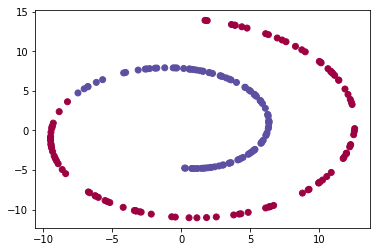

In [17]:
def generate_binary_swiss(target_thresh=9, n_samples=100, plot_opt=True):
    from sklearn.datasets import make_swiss_roll
    # get 3d swisss
    X, color = make_swiss_roll(n_samples=n_samples, random_state=42)
    # get relevant two dimensions
    X = np.c_[X[:,0], X[:,2]]
    # set target with color threshold
    target = np.where(color>target_thresh, 0, 1)
    if plot_opt:
        plt.scatter(X[:,0], X[:,1], c=target, cmap=plt.cm.Spectral)
        plt.show()
    return X, target

X_sw, target_sw = generate_binary_swiss(9, 200)

In [18]:
# Let's try it again with a different dataset
np.random.seed(42)

# prepare data
X_train, X_test, y_train, y_test = train_test_split(X_sw, target_sw, test_size=0.5)
sw_colormap = {'0': 'red', '1': 'green'} 
sw_labelmap = {'0': 'negative', '1': 'positive'} 
sw_labels = [sw_labelmap[str(x)] for x in target_sw]

# classifier 
lr_sw = LogisticRegression(penalty='l2', C=50, solver='newton-cg', multi_class='multinomial')
lr_sw.fit(X_train, y_train)
lr_sw_accuracy = lr_sw.score(X_test, y_test)

# plot
plot_decision_boundaries(X_2D=X_sw,
                         targets=target_sw, 
                         labels=sw_labels,
                         trained_clf=lr_sw, 
                         X_test_=X_test, 
                         colormap_=sw_colormap,
                         labelmap_=sw_labelmap,
                         title_=f"Logistic Regression with {100*lr_sw_accuracy:.2f}% Accuracy",
                         xlabel_="X1", ylabel_="X2")

In [19]:
# Let's try it again with a different dataset
np.random.seed(42)

# try with a new classifer
rf_sw = RandomForestClassifier(n_estimators=8, criterion='entropy', n_jobs=-1)
rf_sw.fit(X_train, y_train)
rf_sw_accuracy = rf_sw.score(X_test, y_test)

# plot
plot_decision_boundaries(X_2D=X_sw,
                         targets=target_sw, 
                         labels=sw_labels,
                         trained_clf=rf_sw, 
                         X_test_=X_test, 
                         colormap_=sw_colormap,
                         labelmap_=sw_labelmap,
                         title_=f"Random Forest with {100*rf_sw_accuracy:.2f}% Accuracy",
                         xlabel_="X1", ylabel_="X2")

In [20]:
# Let's try it again with a different dataset
np.random.seed(42)

# try with a new classifer
from sklearn.neural_network import MLPClassifier
mlp_sw = MLPClassifier(activation='relu', hidden_layer_sizes=(8,8), max_iter=500)
mlp_sw.fit(X_train, y_train)
mlp_sw_accuracy = mlp_sw.score(X_test, y_test)

plot_decision_boundaries(X_2D=X_sw,
                         targets=target_sw, 
                         labels=sw_labels,
                         trained_clf=mlp_sw, 
                         X_test_=X_test, 
                         colormap_=sw_colormap,
                         labelmap_=sw_labelmap,
                         title_=f"MLP with {100*mlp_sw_accuracy:.2f}% Accuracy",
                         xlabel_="X1", ylabel_="X2")

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [21]:
# Let's try it again with a different dataset
np.random.seed(42)

# try with a new classifer
mlp_sw = MLPClassifier(activation='relu', hidden_layer_sizes=(16,16), max_iter=500)
mlp_sw.fit(X_train, y_train)
mlp_sw_accuracy = mlp_sw.score(X_test, y_test)

plot_decision_boundaries(X_2D=X_sw,
                         targets=target_sw, 
                         labels=sw_labels,
                         trained_clf=mlp_sw, 
                         X_test_=X_test, 
                         colormap_=sw_colormap,
                         labelmap_=sw_labelmap,
                         title_=f"MLP with {100*mlp_sw_accuracy:.2f}% Accuracy",
                         xlabel_="X1", ylabel_="X2")

/Users/gkaushik/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
